In [ ]:
#This notebook contains LP-DINO implementation for both ARC-AGI and PairedMNIST. First few blocks define core components of network

import torch as t
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset

In [ ]:
class PatchEmbedding(nn.Module): #Won't be used with ARC-AGI
  def __init__(self, img_size, patch_size, inp_dim, embed_dim):
    super(PatchEmbedding, self).__init__()
    self.img_size = img_size
    self.patch_size = patch_size
    self.inp_dim = inp_dim
    self.embed_dim = embed_dim
    self.total_patches = img_size / patch_size
    self.patchification_operation_i = t.nn.Conv2d(inp_dim, embed_dim, patch_size, stride = patch_size)
    self.patchification_operation_o = t.nn.Conv2d(inp_dim, embed_dim, patch_size, stride = patch_size)

  def forward(self, images_in_batch, input_only=False): #input_only mode will be used by decoder
    if input_only:
      patches_i_in_batch = self.patchification_operation_i(images_in_batch) # -> [batch_size, embded_dim, total_patches, total_patches]
      patches_i_in_batch = patches_i_in_batch.flatten(2)
      return patches_i_in_batch
    else:
      input_part = t.squeeze(images_in_batch[:,0,:,:,:])
      output_part = t.squeeze(images_in_batch[:,1,:,:,:])
      if input_part.dim() == 3:
        input_part = input_part.unsqueeze(1) #in case input dim is 1, sueeze operation above would end up geeting rid of that as well, hence need to bring it back
        output_part = output_part.unsqueeze(1)
      patches_i_in_batch = self.patchification_operation_i(input_part) # -> [batch_size, embded_dim, total_patches, total_patches]
      patches_i_in_batch = patches_i_in_batch.flatten(2)  # -> [batch_size, embded_dim, total_patches^2]
      patches_o_in_batch = self.patchification_operation_o(output_part) # -> [batch_size, embded_dim, total_patches, total_patches]
      patches_o_in_batch = patches_o_in_batch.flatten(2)  # -> [batch_size, embded_dim, total_patches^2]
      patches_in_batch = t.cat((patches_i_in_batch, patches_o_in_batch), 2) # -> [batch_size, embded_dim, 2*total_patches^2]
      print(patches_in_batch.size()) #[batchsize, channels, img_dim] is standard conv2d output format in pytorch
      return patches_in_batch

In [ ]:
class Attention(nn.Module):
  def __init__(self, embed_dim):
      super(Attention, self).__init__()
      self.W_q = t.nn.Linear(embed_dim,embed_dim, bias = False)
      self.W_k= t.nn.Linear(embed_dim,embed_dim, bias = False)
      self.W_v = t.nn.Linear(embed_dim,embed_dim, bias = False)

  def forward(self, patches_in_batch, perform_permute=False):
    if perform_permute:
      #nn.linear only considers the last dim hence permute
      Q = self.W_q(patches_in_batch.permute(0,2,1)) # -> [batch_size, 2*total_patches^2, embded_dim]
      K = self.W_k(patches_in_batch.permute(0,2,1))
      V = self.W_v(patches_in_batch.permute(0,2,1))
    else:
      Q = self.W_q(patches_in_batch)
      K = self.W_k(patches_in_batch)
      V = self.W_v(patches_in_batch)
    attention_W = t.matmul(Q, K.transpose(-2,-1))
    print(attention_W.size())
    print(t.sum(attention_W[1,1,:]))
    attention_W = attention_W.softmax(-1).clone() # -> [batch_size, 2*total_patches^2, 2*total_patches^2]
    print(attention_W.size())

    contexualised_patches = t.matmul(attention_W, V)
    print(contexualised_patches.size())
    return contexualised_patches


In [ ]:
class PositionalEmbedding(nn.Module): #three seperate embeddings for row, col, and whether the patch is from input/output
  def __init__(self, total_patches, embed_dim):
      super(PositionalEmbedding, self).__init__()
      self.row_embeds = nn.Embedding(int(total_patches), embed_dim)
      self.col_embeds = nn.Embedding(int(total_patches), embed_dim)
      self.io_embeds = nn.Embedding(2, embed_dim)
  def forward(self, total_patches):
    ola = t.arange(0,total_patches)
    hu = ola.repeat(int(total_patches)).flatten().long()
    uber = ola.repeat_interleave(int(total_patches)).flatten().long()
    return [t.cat((self.col_embeds(hu),self.col_embeds(hu)),0), t.cat((self.row_embeds(uber),self.row_embeds(uber)),0), self.io_embeds(t.tensor([0,1]).repeat_interleave(int(total_patches*total_patches)).long())]

In [ ]:
class ColourEmbedding(nn.Module):  #For creating a unique embedding for each of the possible grid cell colours in ARC-AGI
  def __init__(self, embed_dim):
      super(ColourEmbedding, self).__init__()
      self.colour_embeds = nn.Embedding(10, embed_dim)
  def forward(self, cells):
    return self.colour_embeds(cells)

In [ ]:
class LPDINO(nn.Module): #Encoder class. Set arc_mode to true when using it with ARC AGI. Set teacher_mode to true when instantiating it for the teacher part of encoder
  def __init__(self, arc_mode=False, teacher_mode = False,  img_size_sqrt=30, patch_size=1):
    super(LPDINO, self).__init__()
    self.arc_mode = arc_mode
    self.teacher_mode = teacher_mode

    self.inp_dim = 1
    self.embed_dim = 24
    self.img_size = img_size_sqrt
    self.patch_size = patch_size
    self.total_patches = self.img_size / self.patch_size

    self.patch_embedding_model = PatchEmbedding(self.img_size, self.patch_size, self.inp_dim, self.embed_dim)
    self.positional_embeds_model = PositionalEmbedding(self.total_patches, self.embed_dim)

    self.attention_1 = Attention(self.embed_dim)
    self.embed_dim_2 = 16
    self.mlp_1 = nn.Linear(self.embed_dim,self.embed_dim_2,bias=True) # -> [batch_size, 2*total_patches^2, embded_dim_2]
    self.relu = nn.ReLU()
    self.attention_2 = Attention(self.embed_dim_2)
    self.embed_dim_3 = 8
    self.mlp_2 = nn.Linear(self.embed_dim_2,self.embed_dim_3,bias=True) # -> [batch_size, 2*total_patches^2, embded_dim_3]
    self.attention_3 = Attention(self.embed_dim_3)
    self.latent_dim = 4
    self.mu = nn.Linear(int(2*self.total_patches*self.total_patches*self.embed_dim_3), self.latent_dim)
    self.sigma = nn.Linear(int(2*self.total_patches*self.total_patches*self.embed_dim_3) ,self.latent_dim)
    self.projection_head_mu = nn.Linear(self.latent_dim, self.latent_dim) #Symmetry breaker
    self.projection_head_sigma = nn.Linear(self.latent_dim, self.latent_dim)

  def forward(self, images_in_batch):
    if self.arc_mode:
      patch_embeds = images_in_batch
    else:
      print(images_in_batch) #[batch_size, 2, inp_channels, w, h]
      patch_embeds = self.patch_embedding_model(images_in_batch)
    positional_embeds = self.positional_embeds_model(self.total_patches)
    print(patch_embeds.size())
    patch_embeds = patch_embeds + positional_embeds[0].t() + positional_embeds[1].t() + positional_embeds[2].t()

    contexualised_patch_embeds_1 = self.relu(self.mlp_1(self.attention_1(patch_embeds, True)))
    print(contexualised_patch_embeds_1.size())
    contexualised_patch_embeds_2 = self.relu(self.mlp_2(self.attention_2(contexualised_patch_embeds_1)))
    contexualised_patch_embeds_3 = self.attention_3(contexualised_patch_embeds_2).flatten(1)
    if self.teacher_mode:
      return [self.mu(contexualised_patch_embeds_3), self.sigma(contexualised_patch_embeds_3)]
    else:
      return [self.projection_head_mu(self.relu(self.mu(contexualised_patch_embeds_3))), self.projection_head_sigma(self.relu(self.sigma(contexualised_patch_embeds_3)))]

In [ ]:
class LPDINO_Predictor(nn.Module):
  def __init__(self, arc_mode, cross_entropy_mode = True, img_size_sqrt=30, patch_size=1):
    super(LPDINO_Predictor, self).__init__()
    self.arc_mode = arc_mode
    self.batch_size = 3
    self.inp_dim = 1
    self.embed_dim = 24
    self.img_size = img_size_sqrt
    self.patch_size = patch_size
    self.total_patches = self.img_size / self.patch_size

    self.patch_embedding_model = PatchEmbedding(self.img_size, self.patch_size, self.inp_dim, self.embed_dim)
    self.attention_1 = Attention(self.embed_dim)
    self.embed_dim_2 = 16
    self.mlp_1 = nn.Linear(self.embed_dim,self.embed_dim_2,bias=True) # -> [batch_size, total_patches^2, embded_dim_2]
    self.relu = nn.ReLU()
    self.attention_2 = Attention(self.embed_dim_2)
    self.embed_dim_3 = 8
    self.mlp_2 = nn.Linear(self.embed_dim_2,self.embed_dim_3,bias=True) # -> [batch_size, total_patches^2, embded_dim_3]
    self.attention_3 = Attention(self.embed_dim_3)
    self.input_img_latent_dim = 128
    self.input_img_latent_mlp = nn.Linear(int(self.total_patches*self.total_patches*self.embed_dim_3), self.input_img_latent_dim)

    self.program_dim = 4
    if cross_entropy_mode:
      self.output_image_mlp = nn.Linear(self.program_dim  + self.input_img_latent_dim, self.img_size * self.img_size * 10)
    else:
      self.output_image_mlp = nn.Linear(self.program_dim  + self.input_img_latent_dim, self.img_size * self.img_size)

  def forward(self, images_in_batch, program): #[batch_size, inp_channels, w, h]
    if self.arc_mode:
      patch_embeds = images_in_batch
    else:
      print(images_in_batch)
      patch_embeds = self.patch_embedding_model(images_in_batch, True)

    contexualised_patch_embeds_1 = self.relu(self.mlp_1(self.attention_1(patch_embeds, True)))
    print(contexualised_patch_embeds_1.size())
    contexualised_patch_embeds_2 = self.relu(self.mlp_2(self.attention_2(contexualised_patch_embeds_1)))
    contexualised_patch_embeds_3 = self.attention_3(contexualised_patch_embeds_2).flatten(1)
    input_img_latent = self.input_img_latent_mlp(contexualised_patch_embeds_3)
    print(input_img_latent.shape)
    print(t.cat((input_img_latent, program.unsqueeze(0).repeat(self.batch_size,1)), 1).shape)
    output_image = self.output_image_mlp(t.cat((input_img_latent, program.unsqueeze(0).repeat(self.batch_size,1)), 1)) #takes as input the concatenation of program and inmput image latent (for each item in batch)
    return output_image

In [ ]:
import json
import torch
from torch.utils.data import Dataset
import torch.nn.functional as F

class ARCDataset(Dataset):
    def __init__(self, jsonl_paths):
        self.internal_task_offset = 0
        self.file_paths = []
        self.line_offsets = [[],[],[]]
        i = 0
        for jsonl_path in jsonl_paths:
          self.file_paths.append(jsonl_path)
          with open(jsonl_path, 'r', encoding='utf-8') as f:
              offset = 0
              for line in f:
                  self.line_offsets[i].append(offset)
                  offset += len(line.encode('utf-8'))
          i += 1

    def __len__(self):
        return len(self.line_offsets[0])


    def pad_grid(self, grid): #Make gird size uniform to 30*30
        H, W = grid.shape
        pad_H = 30 - H
        pad_W = 30 - W
        padded = F.pad(grid, pad=(0, pad_W, 0, pad_H), mode='constant', value=0)
        return padded

    def __getitem__(self, idx):
        print(self.internal_task_offset)
        with open(self.file_paths[self.internal_task_offset], 'r', encoding='utf-8') as f:
            f.seek(self.line_offsets[self.internal_task_offset][idx])
            line = f.readline()
            obj = json.loads(line)

        x = self.pad_grid(torch.tensor(obj['input']))
        y = self.pad_grid(torch.tensor(obj['output']))
        self.internal_task_offset += 1
        if self.internal_task_offset == 3:
          self.internal_task_offset = 0
        return torch.stack((x, y), dim=0)


In [ ]:
dataset = ARCDataset(['/content/drive/MyDrive/re_arc/tasks/007bbfb7.jsonl', '/content/drive/MyDrive/re_arc/tasks/00d62c1b.jsonl', '/content/drive/MyDrive/re_arc/tasks/017c7c7b.jsonl'])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=9, shuffle=True)

for egjample in dataloader:
    print(egjample.unsqueeze(2).shape)
    break

0
1
2
0
1
2
0
1
2
torch.Size([9, 2, 1, 30, 30])


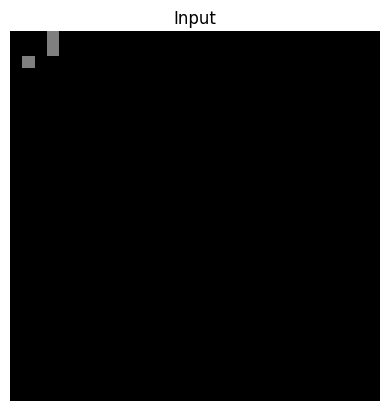

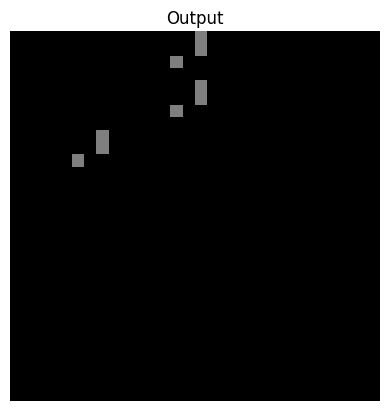

In [ ]:
#Grid visualisation

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

COLOR_MAP = [
    "#000000", "#1f77b4", "#2ca02c", "#d62728", "#9467bd",
    "#8c564b", "#e377c2", "#7f7f7f", "#bcbd22", "#17becf"
]

def visualize_grid(array, title):
    if array.dim() == 3:
        array = array.squeeze(0)  # remove batch dim

    array = array.cpu().numpy()
    rgb_image = np.zeros((array.shape[0], array.shape[1], 3))

    for i in range(10):
        mask = array == i
        color = np.array(mcolors.to_rgb(COLOR_MAP[i]))
        rgb_image[mask] = color

    plt.imshow(rgb_image)
    plt.axis('off')
    if title:
        plt.title(title)
    plt.show()


x = egjample.unsqueeze(2)[0,0,0,:,:]
y = egjample.unsqueeze(2)[0,1,0,:,:]
visualize_grid(x, title="Input")
visualize_grid(y, title="Output")


In [ ]:
c = ColourEmbedding(24)
student = LPDINO(arc_mode=True, teacher_mode=False)
teacher = LPDINO(arc_mode=True, teacher_mode=True)
predictor = LPDINO_Predictor(arc_mode=True)

optimizer = torch.optim.Adam(list(c.parameters()) + list(student.parameters()), lr = 0.001) #Optimiser for the encoder part
optimizer_wholenet = torch.optim.Adam(list(predictor.parameters()) + list(c.parameters()) + list(student.parameters()), lr = 0.001)

loss_function = nn.CrossEntropyLoss() #Contrastive loss
loss_function_wholenet = nn.CrossEntropyLoss() #Prediction loss
contrastive_losses_record = []
prediction_losses_record = []
accuracies_record = []

current_epoch = 0
i = 0
for examples in dataloader:
  examples_student = examples[:3,:,:,:]
  examples_teacher = examples[3:6,:,:,:]
  x_predictor = examples[6:,0,:,:].squeeze()
  optimizer.zero_grad()
  optimizer_wholenet.zero_grad()

  student_latent = student(c(examples_student).permute(0,4,1,2,3).flatten(2))[0]
  teacher_latent = teacher(c(examples_student).permute(0,4,1,2,3).flatten(2))[0].detach()

  temprature_student = 0.1
  temprature_teacher = 0.04
  student_probdist = F.log_softmax(student_latent / temprature_student, dim=1)
  teacher_probdist = F.softmax(teacher_latent / temprature_teacher, dim=1)
  if current_epoch % 2 == 0:
    loss = F.kl_div(student_probdist, teacher_probdist, reduction="batchmean")
    z = student_latent.clone()
    z_centered = z - z.mean(dim=0, keepdim=True)
    cov = (z_centered.T @ z_centered) / (z_centered.shape[0] - 1)
    off_diag = ~torch.eye(cov.size(0), dtype=torch.bool, device=cov.device)
    cov_loss = (cov[off_diag] ** 2).sum()
    loss = loss + cov_loss
    loss.backward()
    optimizer.step()
    contrastive_losses_record.append(loss.item())
  else:
    student_latent_cloned = student_latent.clone()
    decoded_img = predictor(torch.flatten(c(x_predictor).permute(0,3,1,2), 2), student_latent_cloned.mean(dim=0)).view(-1, 900, 10)
    #print(decoded_img.size())
    baseline = torch.squeeze(examples[6:,1,:,:]).flatten(1)
    loss_wholenet = loss_function_wholenet(decoded_img.reshape(-1, 10), baseline.reshape(-1))
    loss_wholenet.backward()
    optimizer_wholenet.step()
    prediction_losses_record.append(loss_wholenet.item())
    with torch.no_grad():
      preds = torch.argmax(decoded_img.reshape(-1, 10), dim=-1)
      accuracy = (preds == baseline.reshape(-1)).float().mean()
      accuracies_record.append(accuracy.item())
    i += 1
    if i == 50:
      break

  with torch.no_grad():
    for params_t, params_s in zip(teacher.parameters(), student.parameters()): #ema for teacher
      momentum = 0.996 # as recommended by dino's original paper
      params_t.data = momentum * params_t.data + (1 - momentum) * params_s.data

  current_epoch += 1

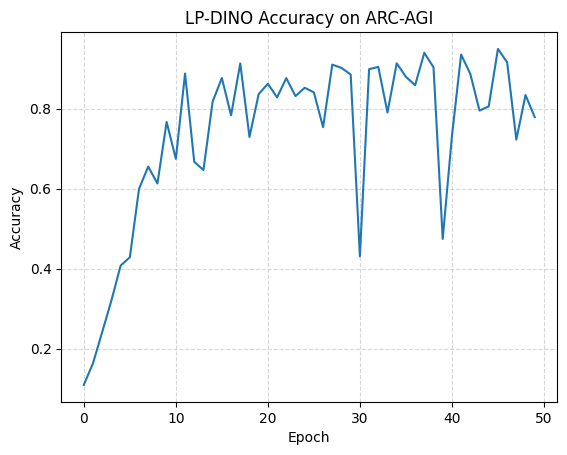

In [ ]:
plt.plot(accuracies_record)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("LP-DINO Accuracy on ARC-AGI")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [ ]:
#Now some evaluation. First generate some outputs using the trained model for evaluation purpose

student.eval()
all_feats, all_labels = [], []
epochs = 0
with torch.no_grad():
    i = 0
    for examples in dataloader:
        # shape: (B, D)
        feats = student(c(examples).permute(0,4,1,2,3).flatten(2))[0]
        all_feats.append(feats.cpu().numpy())
        all_labels.append([0,1,2,0,1,2,0,1,2])
        i += 1
        epochs += 1
        if epochs == 30:
          break
        if i == 3:
          i = 0

X = np.concatenate(all_feats, axis=0)    # → (N, D)
y = np.concatenate(all_labels, axis=0)   # → (N,)


In [ ]:
from sklearn.metrics import calinski_harabasz_score
ch_score = calinski_harabasz_score(X, y)
print(f"Calinski–Harabasz Index: {ch_score:.2f}")

X_rand = np.random.randn(*X.shape)
ch_rand = calinski_harabasz_score(X_rand, y)
print("Random baseline CH:", ch_rand)

Calinski–Harabasz Index: 24.56
Random baseline CH: 0.8312111433620614


In [ ]:
clusters = np.unique(y)
wcss = 0.0
N_total = 0

for cls in clusters:
    Xc = X[y == cls]               # (Nc, D)
    Nc = Xc.shape[0]
    if Nc == 0:
        continue
    centroid = Xc.mean(axis=0)     # (D,)
    # sum of squared distances to the centroid
    wcss_cls = np.sum((Xc - centroid) ** 2)
    wcss += wcss_cls
    N_total += Nc

# 1) Total within cluster sum of squares
print("Total WCSS:", wcss)

# 2) Mean squared distance per point
mean_wcss = wcss / N_total
print("Mean within‑cluster squared distance:", mean_wcss)

# 3) Average cluster variances
cluster_vars = []
for cls in clusters:
    Xc = X[y == cls]
    centroid = Xc.mean(axis=0)
    cluster_vars.append(np.mean(np.sum((Xc - centroid) ** 2, axis=1)))
print("Average cluster WCSS:", np.mean(cluster_vars))


Total WCSS: 0.64791405
Mean within‑cluster squared distance: 0.0023996816
Average cluster WCSS: 0.0023996814


In [ ]:
import random
from sklearn.manifold import TSNE

student.eval()

X_input_list = []
Z_latent_list = []
steps = 0
max_steps = 30

with torch.no_grad():
    for examples in dataloader:
        X_input_list.append(examples.view(examples.size(0), -1).cpu().numpy())

        feats = student(
            c(examples)
              .permute(0,4,1,2,3)
              .flatten(2)
        )[0]
        Z_latent_list.append(feats.cpu().numpy())

        steps += 1
        if steps >= max_steps:
            break

X_input = np.concatenate(X_input_list, axis=0)
Z_latent = np.concatenate(Z_latent_list, axis=0)

def estimate_lipschitz(X, Z, num_pairs=5000):
    N = X.shape[0]
    ratios, inv_ratios = [], []
    for _ in range(num_pairs):
        i, j = random.randrange(N), random.randrange(N)
        if i == j:
            continue
        dx = np.linalg.norm(X[i] - X[j])
        dz = np.linalg.norm(Z[i] - Z[j])
        if dx > 0:
            ratios.append(dz / dx)
        if dz > 0:
            inv_ratios.append(dx / dz)
    L_est = float(np.max(ratios))
    m_est = float(np.min(inv_ratios))
    return L_est, m_est

L_est, m_est = estimate_lipschitz(X_input, Z_latent, num_pairs=2000)
print(f"Estimated upper Lipschitz constant L ≈ {L_est:.3f}")
print(f"Estimated lower‑Lipschitz bound m ≈ {m_est:.3f}")


0
1
2
0
1
2
0
1
2
torch.Size([9, 24, 1800])
torch.Size([9, 1800, 1800])
tensor(12428.6895)
torch.Size([9, 1800, 1800])
torch.Size([9, 1800, 24])
torch.Size([9, 1800, 16])
torch.Size([9, 1800, 1800])
tensor(1034.1360)
torch.Size([9, 1800, 1800])
torch.Size([9, 1800, 16])
torch.Size([9, 1800, 1800])
tensor(0.)
torch.Size([9, 1800, 1800])
torch.Size([9, 1800, 8])
0
1
2
0
1
2
0
1
2
torch.Size([9, 24, 1800])
torch.Size([9, 1800, 1800])
tensor(18742.5938)
torch.Size([9, 1800, 1800])
torch.Size([9, 1800, 24])
torch.Size([9, 1800, 16])
torch.Size([9, 1800, 1800])
tensor(1062.2502)
torch.Size([9, 1800, 1800])
torch.Size([9, 1800, 16])
torch.Size([9, 1800, 1800])
tensor(0.)
torch.Size([9, 1800, 1800])
torch.Size([9, 1800, 8])
0
1
2
0
1
2
0
1
2
torch.Size([9, 24, 1800])
torch.Size([9, 1800, 1800])
tensor(11789.8906)
torch.Size([9, 1800, 1800])
torch.Size([9, 1800, 24])
torch.Size([9, 1800, 16])
torch.Size([9, 1800, 1800])
tensor(745.5270)
torch.Size([9, 1800, 1800])
torch.Size([9, 1800, 16])
torc

/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


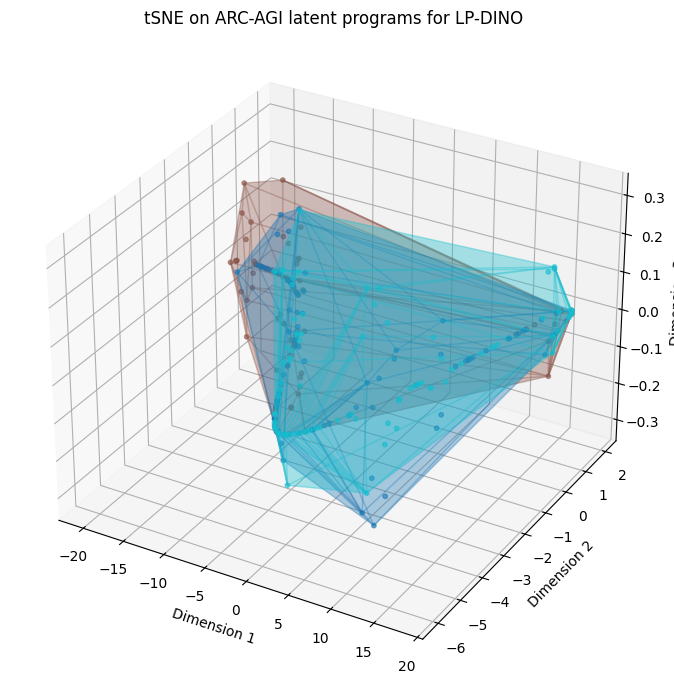

In [ ]:
#tSNE plot
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.manifold import TSNE

tsne3 = TSNE(
    n_components=3,
    init="pca",
    perplexity=min(30, len(X)-1),  # keep < N
    n_iter=1000,
    random_state=42
)
X3 = tsne3.fit_transform(X)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')
cmap = plt.get_cmap("tab10", len(np.unique(y)))

for idx, cls in enumerate(np.unique(y)):
    pts = X3[y == cls]
    color = cmap(idx)

    ax.scatter(pts[:,0], pts[:,1], pts[:,2], color=color, s=10, alpha=0.6)

    if pts.shape[0] >= 4:
        hull = ConvexHull(pts)
        faces = hull.simplices
        mesh = Poly3DCollection(
            [pts[face] for face in faces],
            facecolor=color, alpha=0.2, edgecolor=color
        )
        ax.add_collection3d(mesh)

ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
ax.set_title("tSNE on ARC-AGI latent programs for LP-DINO")
plt.tight_layout()
plt.show()
fig.savefig("tsne_3d.png", dpi=300, bbox_inches="tight", pad_inches=0.1)


In [ ]:
teacher_latent.requires_grad

False

In [ ]:
student_latent.mean(dim=0).shape

torch.Size([12])

# Paired MNIST

In [ ]:
#Creates paired samples of consecutive digit images
class PairedMNISTDataset(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.paired_indices = self.create_paired_indices()

    def create_paired_indices(self):
        pairs = []
        targets = np.array([self.dataset[i][1] for i in range(len(self.dataset))])
        for i in range(0, 9):  # Pair conjecutive digits
            indices1 = np.where(targets == i)[0]
            indices2 = np.where(targets == i + 1)[0]
            for idx1 in indices1:
                if len(indices2) > 0:
                    idx2 = np.random.choice(indices2)
                    pairs.append((idx1, idx2))
        return pairs

    def __len__(self):
        return len(self.paired_indices)

    def __getitem__(self, idx):
        index1, index2 = self.paired_indices[idx]
        img_i, _ = self.dataset[index1]
        img_o, _ = self.dataset[index2]
        pair = t.stack((img_i, img_o), dim=0)  # COMBINE
        return pair

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((40, 40)),
    transforms.ToTensor(),
])

mnist_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
paired_mnist_dataset = PairedMNISTDataset(mnist_dataset)

100%|██████████| 9.91M/9.91M [00:00<00:00, 53.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.75MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.84MB/s]


In [ ]:
paired_mnist_dataloader = torch.utils.data.DataLoader(paired_mnist_dataset, batch_size=9, shuffle=True)

for egjample in paired_mnist_dataloader:
    print(egjample.shape)
    break

torch.Size([9, 2, 1, 40, 40])


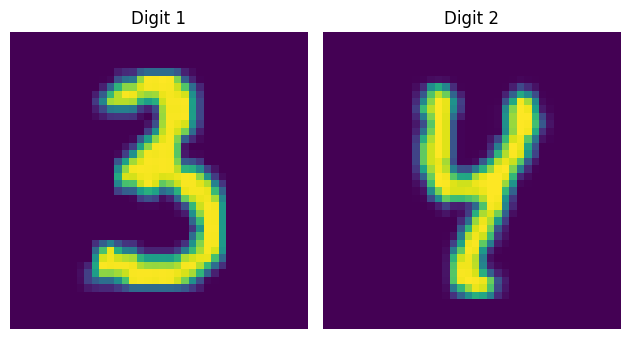

In [ ]:
import matplotlib.pyplot as plt
figure, axes = plt.subplots(1, 2)
axes[0].imshow(egjample[0,0,0,:,:].squeeze())
axes[0].set_title("Digit 1")
axes[0].axis('off')

axes[1].imshow(egjample[0,1,0,:,:].squeeze())
axes[1].set_title("Digit 2")
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
student = LPDINO(arc_mode=False, teacher_mode=False, img_size_sqrt=40, patch_size=5)
teacher = LPDINO(arc_mode=False, teacher_mode=True, img_size_sqrt=40, patch_size=5)
predictor = LPDINO_Predictor(arc_mode=False, cross_entropy_mode=False, img_size_sqrt=40, patch_size=5)

optimizer = torch.optim.Adam(list(student.parameters()), lr = 0.001) #optimiser for the encoder part
optimizer_wholenet = torch.optim.Adam(list(predictor.parameters()) + list(student.parameters()), lr = 0.001)

loss_function = nn.CrossEntropyLoss() #Contrastive Loss
loss_function_wholenet = nn.MSELoss() #Prediction Loss
contrastive_losses_record = []
prediction_losses_record = []
accuracies_record = []

current_epoch = 0
i = 0
for examples in paired_mnist_dataloader:
  examples_student = examples[:3,:,:,:]
  examples_teacher = examples[3:6,:,:,:]
  x_predictor = examples[6:,0,:,:].squeeze()
  optimizer.zero_grad()
  optimizer_wholenet.zero_grad()

  student_latent = student(examples_student)[0]
  teacher_latent = teacher(examples_teacher)[0].detach()

  temprature_student = 0.1
  temprature_teacher = 0.04
  student_probdist = F.log_softmax(student_latent / temprature_student, dim=1)
  teacher_probdist = F.softmax(teacher_latent / temprature_teacher, dim=1)
  if current_epoch % 2 == 0:
    loss = F.kl_div(student_probdist, teacher_probdist, reduction="batchmean")
    loss.backward()
    optimizer.step()
    contrastive_losses_record.append(loss.item())
  else:
    student_latent_cloned = student_latent.clone()
    decoded_img = predictor(x_predictor.unsqueeze(1), student_latent_cloned.mean(dim=0))
    prediction_loss = loss_function_wholenet(decoded_img , examples[6:,1,:,:,:].squeeze().flatten(1).float())
    prediction_losses_record.append(prediction_loss.item())
    prediction_loss.backward()
    optimizer_wholenet.step()
    with torch.no_grad():
      absolute_error = torch.abs(decoded_img - examples[6:,1,:,:,:].squeeze().flatten(1).float())
      correct_pixels = (absolute_error < 0.15).float() #Margin of acceptable pixel intensity error = 15%
      accuracies_record.append(correct_pixels.mean().item())
    i += 1
    if i == 50:
      break


  with torch.no_grad():
    for params_t, params_s in zip(teacher.parameters(), student.parameters()): #ema for teacher
      momentum = 0.996
      params_t.data = momentum * params_t.data + (1 - momentum) * params_s.data

  current_epoch += 1

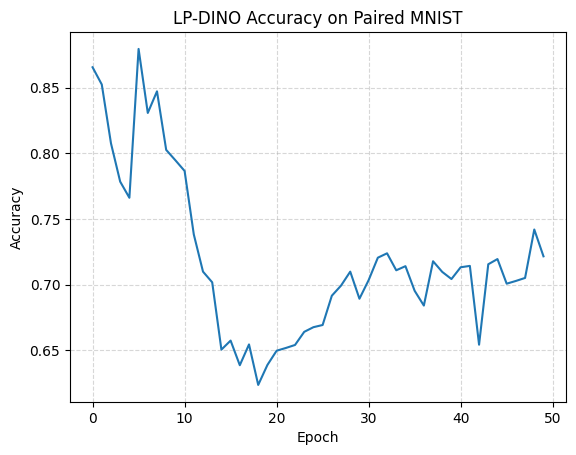

In [ ]:
plt.plot(accuracies_record)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("LP-DINO Accuracy on Paired MNIST")
plt.grid(True, linestyle="--", alpha=0.5)
plt.show()

In [ ]:
prediction_losses_record

[0.07915344089269638,
 0.09845592826604843,
 0.05249986797571182,
 0.08023922890424728,
 0.07983783632516861,
 0.09828110039234161,
 0.09456704556941986,
 0.07572320103645325,
 0.065591961145401,
 0.09598100185394287,
 0.06962650269269943,
 0.06465353071689606,
 0.058692220598459244,
 0.057500891387462616,
 0.057013798505067825,
 0.053751952946186066,
 0.04438735172152519,
 0.05129947513341904,
 0.07577230781316757,
 0.0766998752951622,
 0.061262618750333786,
 0.06030857190489769,
 0.05021555349230766,
 0.050637807697057724,
 0.049372583627700806,
 0.053786005824804306,
 0.0470866821706295,
 0.04889057204127312,
 0.05212640017271042,
 0.046075642108917236,
 0.04923617094755173,
 0.07890172302722931,
 0.0638447031378746,
 0.07569045573472977,
 0.04362732172012329,
 0.05658724531531334,
 0.06541188061237335,
 0.051754508167505264,
 0.04248197376728058,
 0.047529079020023346,
 0.058532293885946274,
 0.0674731433391571,
 0.047708846628665924,
 0.047196876257658005,
 0.04897206649184227,
 0

In [ ]:
x_predictor.unsqueeze(1).shape

torch.Size([3, 1, 40, 40])